<a href="https://colab.research.google.com/github/DavideScassola/PML2024/blob/main/./Notebooks/10_BNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 10: Bayesian Neural Networks

The notebook is a revisitation of [this tutorial](https://towardsdatascience.com/making-your-neural-network-say-i-dont-know-bayesian-nns-using-pyro-and-pytorch-b1c24e6ab8cd).

![](https://github.com/charlesollion/dlexperiments/raw/master/6-Bayesian-DL/BDLworkflow.png)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from matplotlib.pyplot import imread
%matplotlib inline

import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:

class NN(nn.Module):
	
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('~/.pytorch/MNIST_data', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('~/.pytorch/MNIST_data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)

net = NN(28*28, 1024, 10)

In [3]:
log_softmax = nn.LogSoftmax(dim=1)

In [20]:
def model(x_data, y_data):
    
    # TODO: Create a prior for the weights and biases
    

    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    lifted_reg_model = lifted_module()
    
    #TODO: sample from the output of the neural network and condition on the observed data
    
    


In [24]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):

    # TODO: Create a variational distribution for the weights and biases of each layer of the neural network
    # and define the parameters (as pyro.param) for the variational distribution
    
   
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [25]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [26]:
num_iterations = 5
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,28*28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

Epoch  0  Loss  95.57316843028069
Epoch  1  Loss  89.72669575643539
Epoch  2  Loss  87.57889758296012
Epoch  3  Loss  85.59944080352783
Epoch  4  Loss  85.9565016151905


In [8]:

num_samples = 10
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1)

print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in enumerate(test_loader):
    images, labels = data
    predicted = predict(images.view(-1,28*28))
    total += labels.size(0)
    correct += (np.array(predicted) == np.array(labels)).sum().item()
print("accuracy: %d %%" % (100 * correct / total))

Prediction when network is forced to predict
accuracy: 88 %


In [9]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
num_samples = 10

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()   
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)

def test_batch(images, labels, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions=0
    for i in range(len(labels)):    
        if(plot):
            print("Real: ",labels[i].item())
            fig, axs = plt.subplots(1, 10, sharey=True,figsize=(20,2)) 
        all_digits_prob = []  
        highted_something = False  
        for j in range(len(classes)):       
            highlight=False    
            histo = []
            histo_exp = []       
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))  
            prob = np.percentile(histo_exp, 50) #sampling median probability
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer       
            all_digits_prob.append(prob)           
            if(plot):           
                N, bins, patches = axs[j].hist(histo, bins=10, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")")      
            if(highlight):        
                highted_something = True           
                if(plot):
                    fracs = N / N.max()
                    norm = colors.Normalize(fracs.min(), fracs.max())
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)   
        if(plot):
            plt.show()
        predicted = np.argmax(all_digits_prob)  
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")    
        if(plot):
            imshow(images[i].squeeze())    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        
    return len(labels), correct_predictions, predicted_for_images 
    
# Prediction when network can decide not to predict

print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))

Prediction when network can refuse
Total images:  10000
Skipped:  1016
Accuracy when made predictions: 91 %


Real:  4


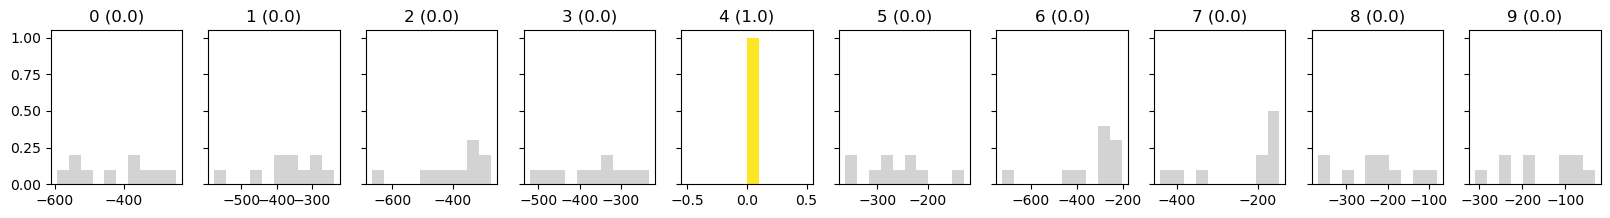

Correct


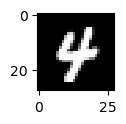

Real:  4


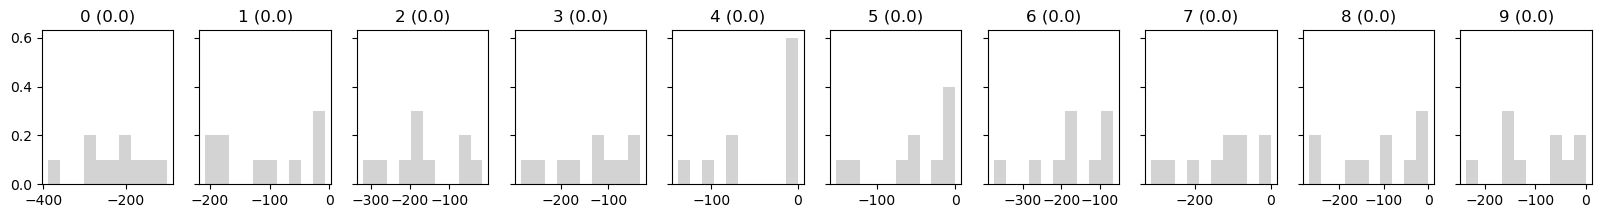

Undecided.


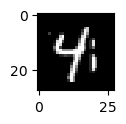

Real:  5


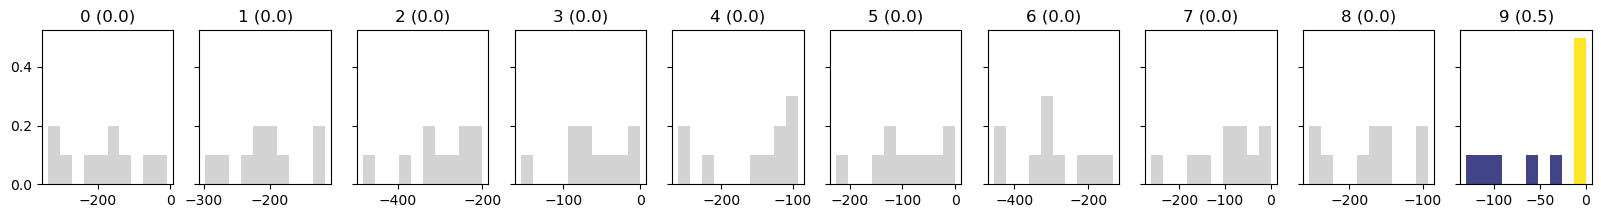

Incorrect :()


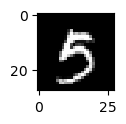

Real:  4


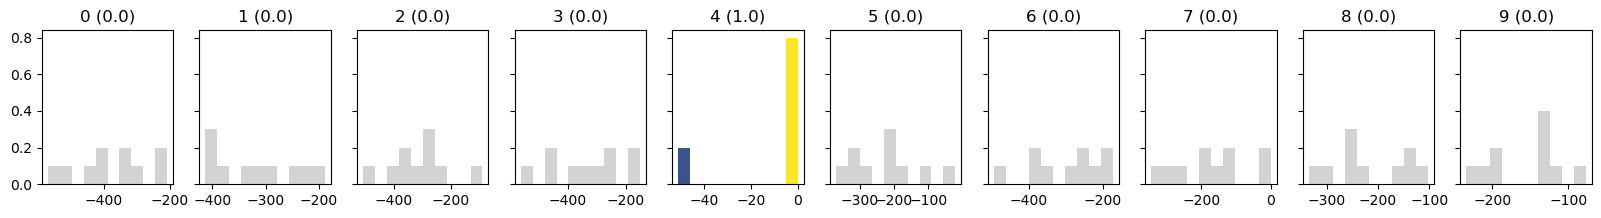

Correct


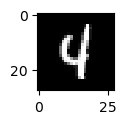

Real:  1


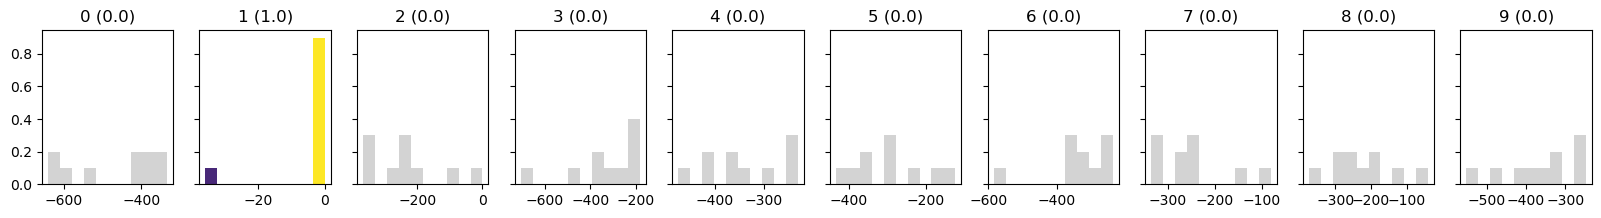

Correct


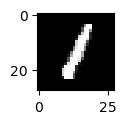

Real:  1


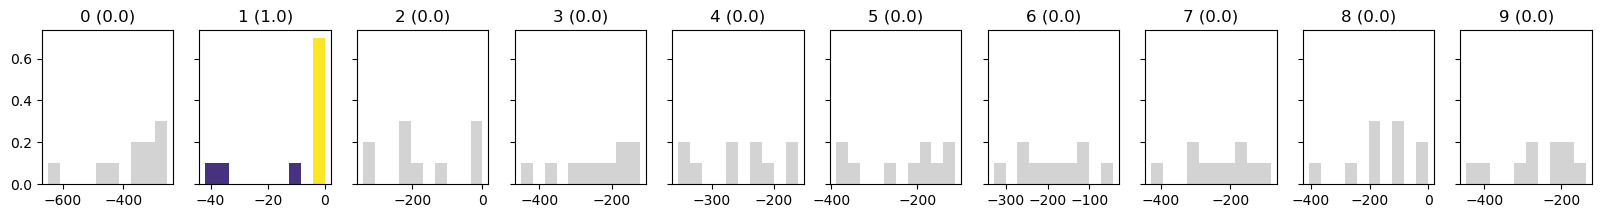

Correct


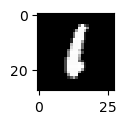

Real:  3


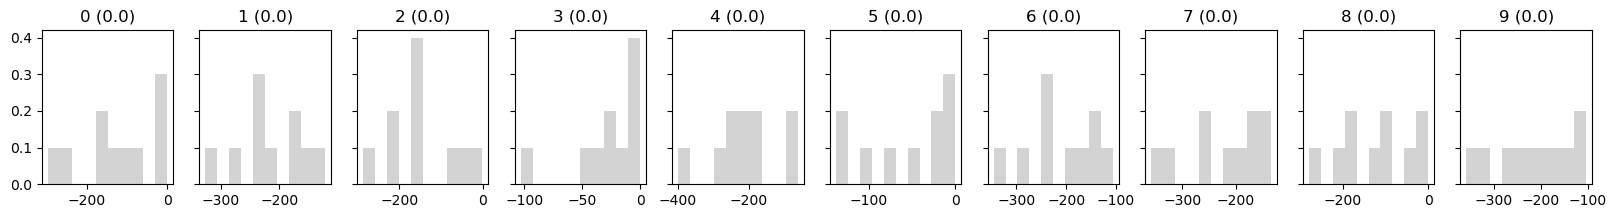

Undecided.


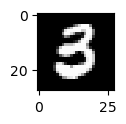

Real:  0


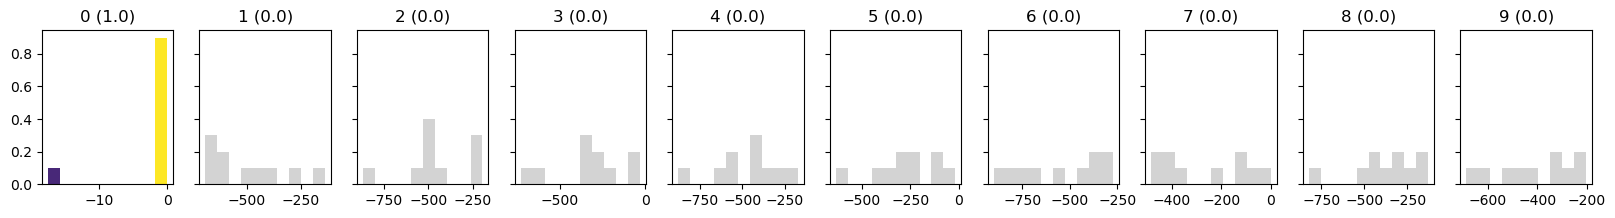

Correct


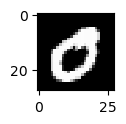

Real:  1


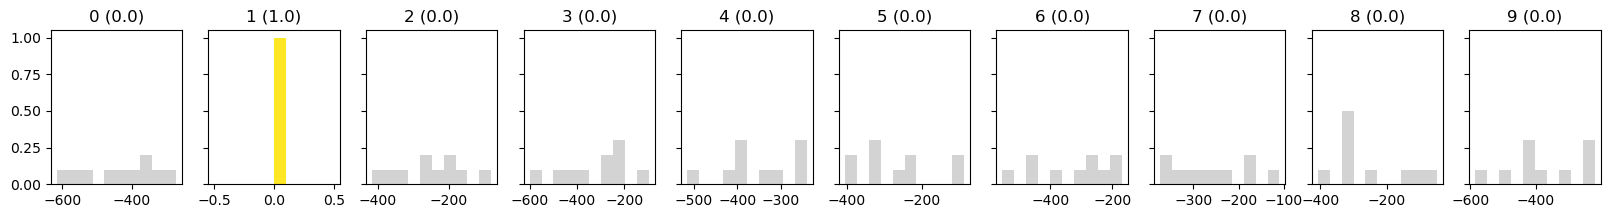

Correct


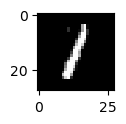

Real:  4


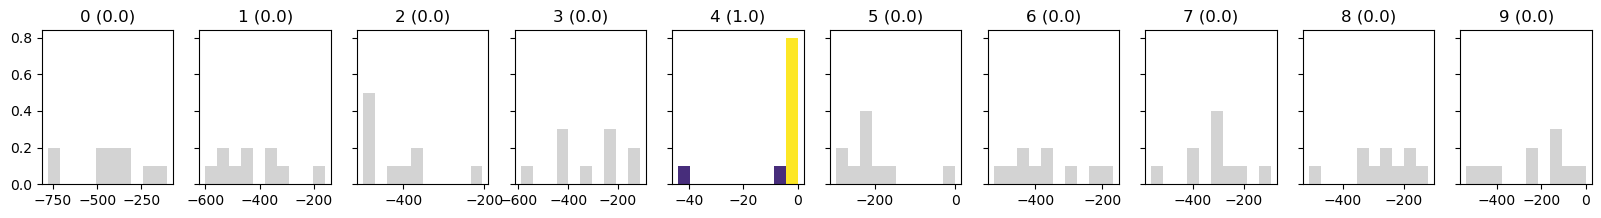

Correct


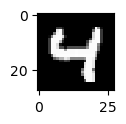

Summary
Total images:  10
Predicted for:  8
Accuracy when predicted:  0.875


In [10]:
for images, labels in test_loader:
    test_batch(images[10:20], labels[10:20])
    break

In [11]:
test_loader_fashion = torch.utils.data.DataLoader(datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', train=False, download = True, transform=transforms.Compose([transforms.ToTensor(),])),batch_size=128, shuffle=True)

tensor([0, 7, 4, 0, 7, 1, 7, 5, 1, 9])
Real:  0


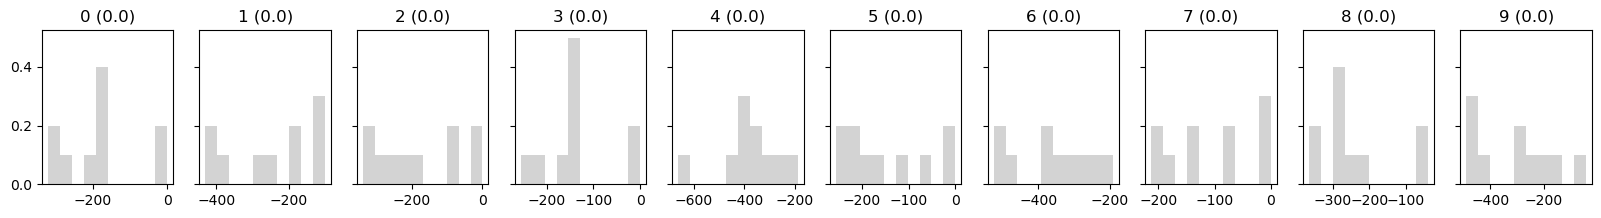

Undecided.


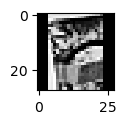

Real:  7


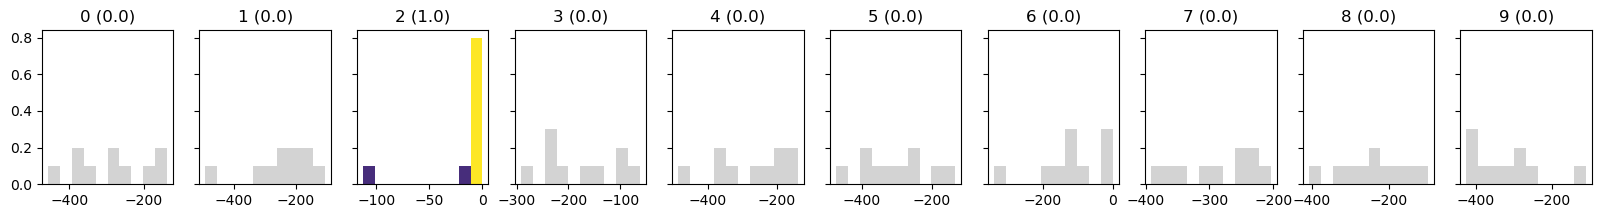

Incorrect :()


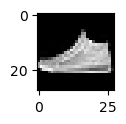

Real:  4


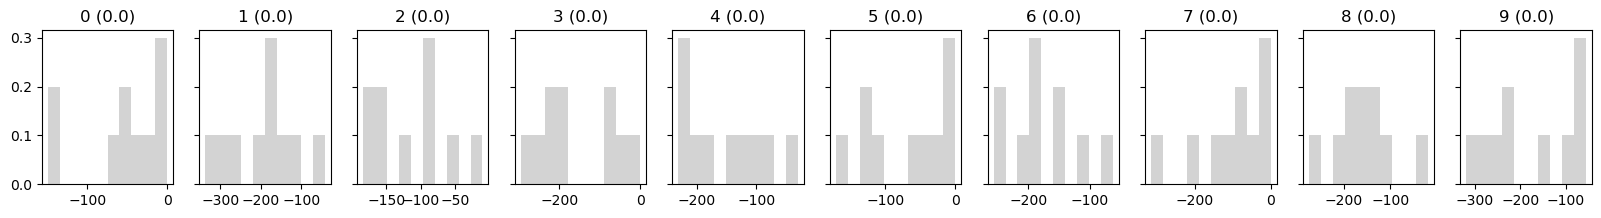

Undecided.


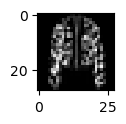

Real:  0


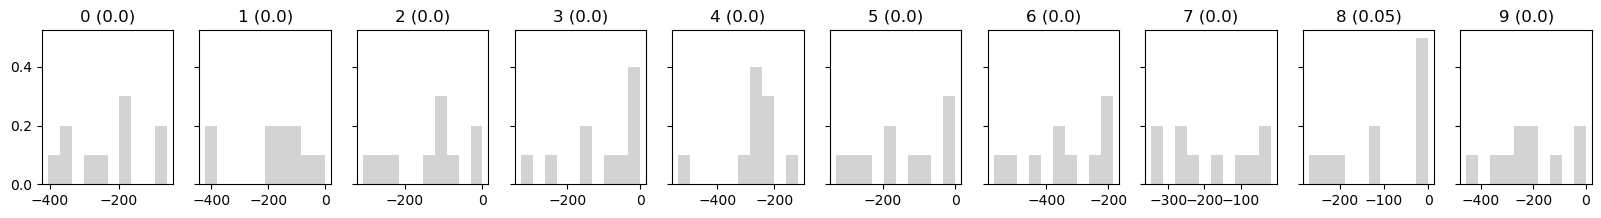

Undecided.


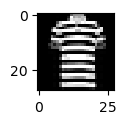

Real:  7


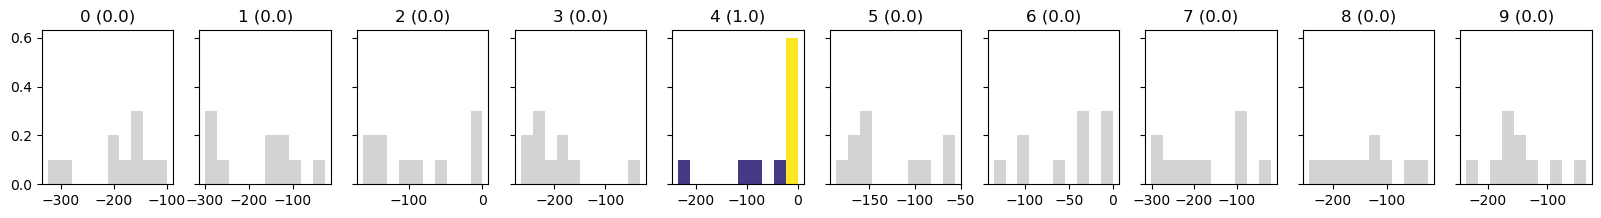

Incorrect :()


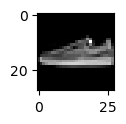

Real:  1


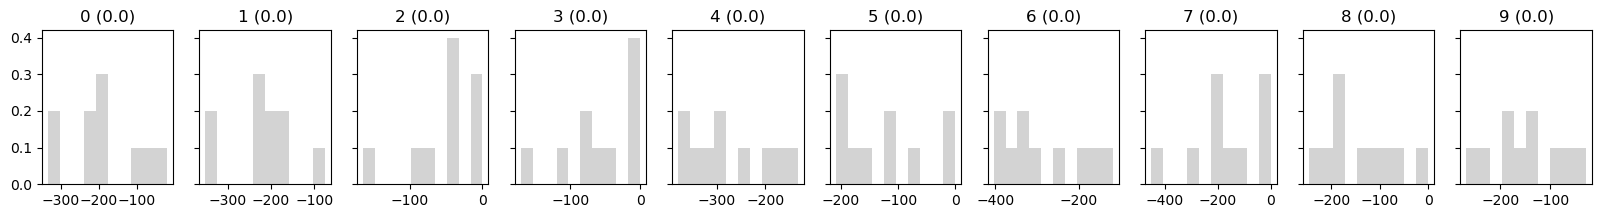

Undecided.


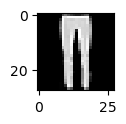

Real:  7


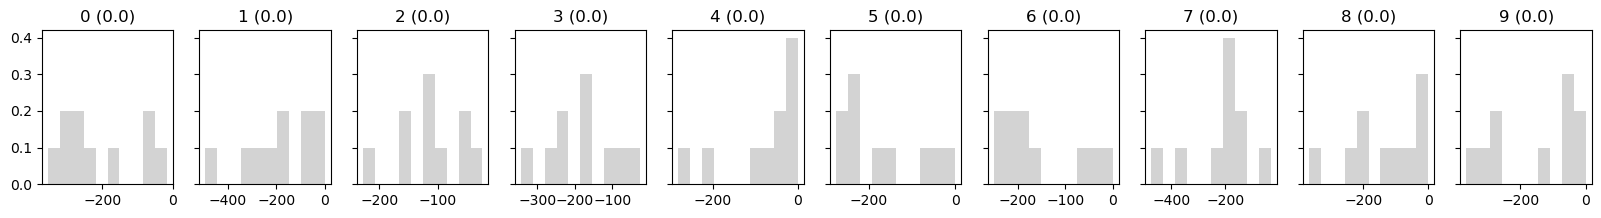

Undecided.


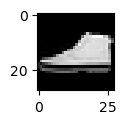

Real:  5


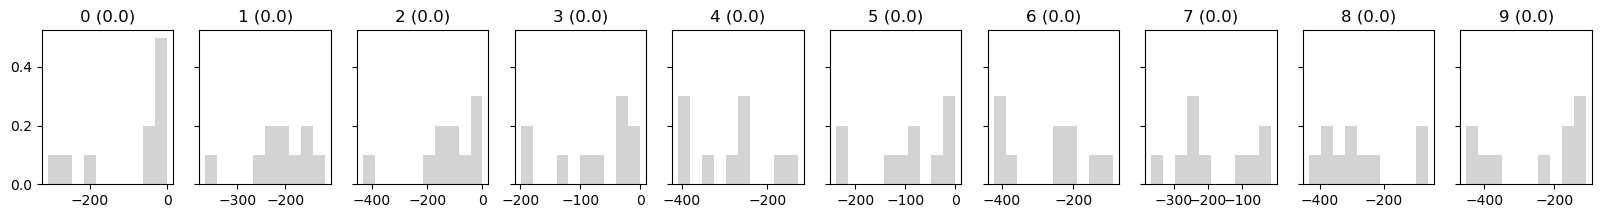

Undecided.


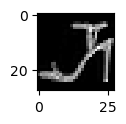

Real:  1


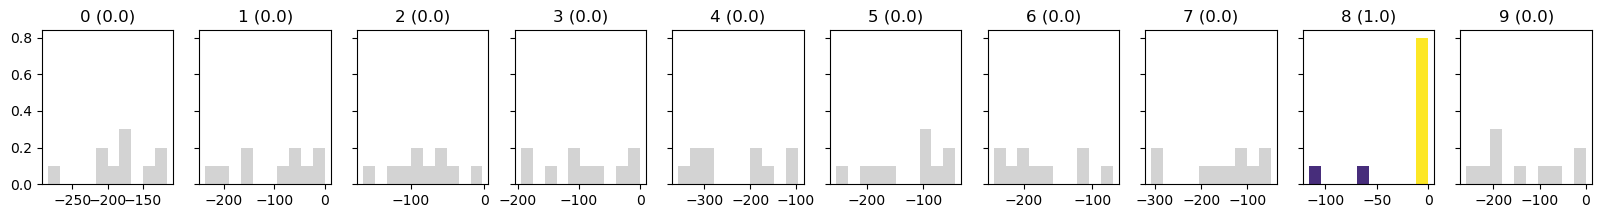

Incorrect :()


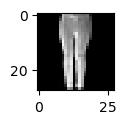

Real:  9


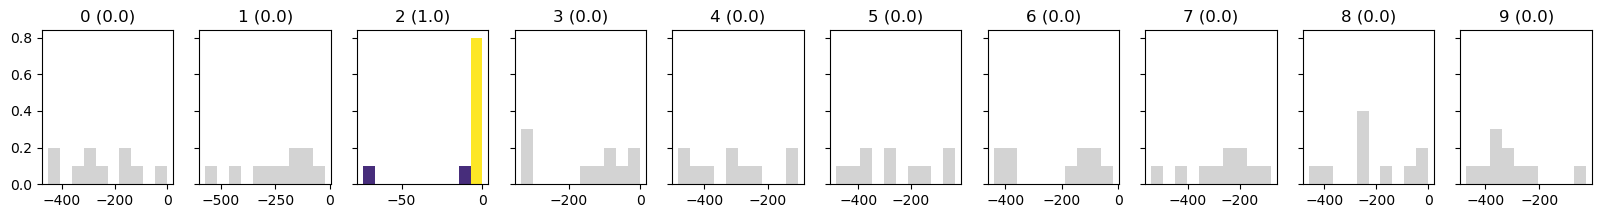

Incorrect :()


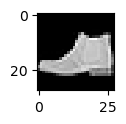

Summary
Total images:  10
Predicted for:  4
Accuracy when predicted:  0.0


In [12]:
for images, labels in test_loader_fashion:
    print(labels[10:20])
    test_batch(images[10:20], labels[10:20])
    break